In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
import os

# Verify
print("Current Working Directory:", os.getcwd())
# Important for analysis, but unlikely to be useful for the model:
    # age_approx, sex, anatom_site_general, tbp_lv_location (area of the body),
# Probably important columns:
    # - attribution, 
    # tbp_lv_symm_2axis (asymmetry),
    # tbp_lv_perimeterMM * (perimeter),
    # tbp_lv_norm_color * (color asymmetry, color irregualirity), 
    # tbp_lv_norm_border (border irregularity), 
    # tbp_lv_areaMM2 * (area), 
    #  * (hue outside lesion), 


def partial_auc(gts, preds, min_tpr=0.8):
    from sklearn.metrics import roc_curve, auc, roc_auc_score

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(gts)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(preds)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    return partial_auc
    
metadata = "/storage/research/med_mlm/data/isic2024/train-metadata.csv"
md_df = pd.read_csv(metadata)
#md_df



Current Working Directory: ../../subgroups_eval


/scratch/local/16299170/ipykernel_1131451/1910211392.py:50: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  md_df = pd.read_csv(metadata)


# Perf. disparity

/scratch/local/16299170/ipykernel_1131451/3407180182.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
/scratch/local/16299170/ipykernel_1131451/3407180182.py:91: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  md_df = pd.read_csv(metadata)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were foun

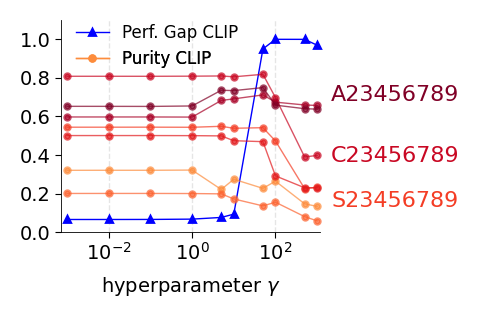

In [58]:
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import matplotlib.colors as mc
import colorsys
import matplotlib.cm as cm
from matplotlib.lines import Line2D


def create_figure(n_rows, linewidth=3.0, axes_height=1.5, axes_width_fraction=0.8,
                  top_margin_inches=0.3, bottom_margin_inches=0.3, vertical_spacing_inches=0.2):
    """
    Creates a figure with n_rows subplots where each subplot (the drawing area)
    has the same fixed width and height.

    Parameters:
      - n_rows: Number of rows of subplots.
      - linewidth: Total figure width in inches.
      - axes_height: Desired height of each subplot's drawing area (in inches).
      - axes_width_fraction: Fraction of the total width that the drawing area should occupy.
      - top_margin_inches, bottom_margin_inches: Top and bottom margins (in inches).
      - vertical_spacing_inches: Vertical space between subplots (in inches).

    Returns:
      - fig: The created figure.
      - axes: A list (or array) of axes objects.
    """
    # Compute overall figure height so that each axes is axes_height tall.
    fig_height = top_margin_inches + bottom_margin_inches + n_rows * axes_height + (n_rows - 1) * vertical_spacing_inches

    # Create the figure with the total width and computed height.
    fig, axes = plt.subplots(n_rows, 1, figsize=(linewidth, fig_height), sharex=True)

    # Determine normalized margins so that the axes drawing area has fixed size.
    left = (1 - axes_width_fraction) / 2
    right = 1 - left
    bottom = bottom_margin_inches / fig_height
    top = 1 - top_margin_inches / fig_height
    # hspace is given relative to the axes height.
    hspace = vertical_spacing_inches / axes_height

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
    return fig, axes
    
split = "test"
# --- Sample Data: Replace with your file paths if reading from disk ---
with plt.style.context("./plot_style.txt"):

    # Create subplots ONCE
    #fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharey=True, layout='constrained')
    cm = 1/2.54  # centimeters in inches
    # Create subplots ONCE
    textwidth = 12.19826*cm
    #fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(textwidth/2, textwidth/2.5))
    fig, ax = create_figure(n_rows=1, linewidth=textwidth/2, axes_height=textwidth/4.8, axes_width_fraction=0.6)

    
    # pick the i-th Axes

    data = "./results/results_persample_l3_isic24_valtest_clip_imagenet_multiple.csv"
    df = pd.read_csv(data)
    #print(df.columns)
    df = df[df["split"] == split]

    df = df.pivot_table(
        index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
        columns=['seed', 'weight', 'n_slices'],
        values='discovered_subgroup_idx'
    ).reset_index()

    def flatten_column(col):
        # If the column is a tuple with exactly 3 elements,
        # assume it's from the pivoted values (seed, weight, n_slices)
        #print(len(col), col)
        if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
            seed, weight, n_slices = col
            return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
        # If it's a tuple with a single element, assume it's an index column
        elif isinstance(col, tuple) and len(col) == 1:
            return col[0]
        return col[0]

    df.columns = [flatten_column(col) for col in df.columns]

    def weight_fn(n, c=50):
        return n / (n + c)

    metadata = "/storage/research/med_mlm/data/isic2024/train-metadata.csv"
    md_df = pd.read_csv(metadata)
    # Rename md_df isic_id to name
    md_df.rename(columns={"isic_id": "name"}, inplace=True)
    # Remove suffix from md_df name .jpg
    df["name"] = df["name"].str.replace(".jpg", "")
    # Train the decision tree on the continuous feature

    quantile = 2
    md_df["class_long_diam_mm"], bins = pd.qcut(md_df['clin_size_long_diam_mm'], q=quantile, labels=False, retbins=True)
    md_df["class_radial_color_std"], bins = pd.qcut(md_df['tbp_lv_radial_color_std_max'], q=quantile, labels=False, retbins=True)
    md_df["class_norm_color"], bins = pd.qcut(md_df['tbp_lv_norm_color'], q=quantile, labels=False, retbins=True)
    md_df["class_perimeter"], bins = pd.qcut(md_df['tbp_lv_perimeterMM'], q=quantile, labels=False, retbins=True)
    md_df["class_area"], bins = pd.qcut(md_df['tbp_lv_areaMM2'], q=quantile, labels=False, retbins=True)  
    md_df["class_age"], bins = pd.qcut(md_df['age_approx'], q=quantile, labels=False, retbins=True)   
 
    #md_df.head()
    df = pd.merge(df, md_df, how="inner", on="name")

    #print(df.columns)
    x = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]

    perf_gaps = []
    for col in df.columns:
        if "discovered_subgroup_idx" in col:
            weight = col.split("_")[4][1:]
            if float(weight) in x:
                # calculate the performance per subgroup
                perf_subgroup = df[[col, "y_true", "y_pred"]].groupby(col).apply(
                    lambda x: pd.Series({
                        "accuracy": accuracy_score(x["y_true"], (x["y_pred"] > 0.5)*1),
                    })
                ).reset_index()
                # get the maximum performance gap across subgroups
                #print("#"*5)
                #print(perf_subgroup)
                perf_gap = perf_subgroup["accuracy"].max() - perf_subgroup["accuracy"].min()
                weight = col.split("_")[4][1:]
                perf_gaps.append(perf_gap)
                #print("perf. gaps", col, weight, perf_gap)
        
    balanced_purr_arr = {}
    md_cols = ["anatom_site_general", "attribution", "sex", "class_age", "class_norm_color", "class_perimeter", "class_area"]
    for md_col in md_cols:
        balanced_purr_arr[md_col] = []
        for col in df.columns:
            if "discovered_subgroup_idx" in col:
                weight = col.split("_")[4][1:]
                if float(weight) in x:
                    subgroups = df.groupby(col)
                    purity = subgroups.apply(
                        lambda x: pd.Series({
                            "number_of_samples": len(x),
                            "majority_true_subgroup_idx": x[md_col].value_counts().idxmax(),
                            "max_purity": x[md_col].value_counts(normalize=True).max()
                        })
                    ).reset_index()
    
                    # Compute adjusted purity for each subgroup
                    purity["adjusted_purity"] = purity.apply(
                        lambda row: row["max_purity"] * weight_fn(row["number_of_samples"]),
                        axis=1
                    )
                    
                    #print(md_col, purity)
                    # For each ground truth subgroup, find the discovered subgroup with the best adjusted purity
                    adjusted_purities_per_group = []
    
                    unique_cols = df[md_col].unique()
    
                    for group_idx in range(len(unique_cols)):
                        grp = purity[purity["majority_true_subgroup_idx"] == unique_cols[group_idx]]
                        if not grp.empty:
                            best_adjusted_purity = grp["adjusted_purity"].max()
                        else:
                            best_adjusted_purity = 0
                        #print(f"Ground truth group {group_idx}: best adjusted purity = {best_adjusted_purity}")
                        adjusted_purities_per_group.append(best_adjusted_purity)
    
                    #print("adjusted purities", adjusted_purities_per_group)
                    balanced_adjusted_purity = np.mean(adjusted_purities_per_group)
                    balanced_purr_arr[md_col].append(balanced_adjusted_purity)
                    #weight = col.split("_")[4][1:]
                    #print("Adjusted purity", weight, col, balanced_adjusted_purity)



    # Define your metadata columns and their custom labels.
    md_cols = ["anatom_site_general", "attribution", "sex", "class_age", "class_norm_color", "class_perimeter", "class_area"]
    custom_labels = ["Anatomical Site", "Source Institution", "Sex", "Age", "Lesion Color Std", "Lesion Perimeter", "Lesion Area"]
    
    # Use the YlOrRd colormap over a restricted range (0.5 to 1.0) to get vivid colors.
    cmap_yellow_red = plt.get_cmap("YlOrRd")
    n = len(md_cols)
    base_colors = {md: cmap_yellow_red(0.5 + 0.5 * i/(n-1)) for i, md in enumerate(md_cols)}

    
    ax.plot(x, perf_gaps, linestyle="solid", marker="^", label="Performance Gap", color="blue", markersize=2, clip_on=False)
    for md in md_cols:
        ax.plot(x, balanced_purr_arr[md],
                    marker="o", linestyle="solid", alpha=0.7, markersize=2, color=base_colors[md], clip_on=False)

    # --- Annotate selected key metadata curves ---
    # We highlight only "Sex", "Age Group", and "Ethnicity".
    selected_md = {
        "class_norm_color": "C23456789",#"Lesion Color",
        "class_area":"A23456789", #"Lesion Area",
        "sex": "S23456789"#"Sex",

    }
    # Offsets (in points) to avoid overlapping text.
    offsets = {
        "class_norm_color": (5, 0),
        "class_area": (5, 5),
        "sex": (5, -5)
    }
    
    for md, label in selected_md.items():
        y_val = balanced_purr_arr[md][-1]
        dx, dy = offsets.get(md, (5, 0))
        ax.annotate(label,
                    xy=(x[-1], y_val),
                    xytext=(dx, dy),
                    textcoords="offset points",
                    ha="left",
                    va="center",
                    color=base_colors[md],
                    fontsize=8
                    )
        

    # --- Create a legend for performance gap curves ---
    perf_handles = [
        Line2D([], [], color='blue', marker="^", markersize=2 , linestyle="solid", label="Perf. Gap CLIP"),
    ]
    perf_legend = ax.legend(handles=perf_handles, loc='upper left', bbox_to_anchor=(0, 1.05), frameon=False)
    ax.add_artist(perf_legend)

    # --- Create a legend for purity curves (metadata-based) ---
    purity_handles = [
        Line2D([], [], color=base_colors["anatom_site_general"], marker="o", markersize=2 , linestyle="solid", label="Purity CLIP"),
    ]
    purity_legend = ax.legend(handles=purity_handles, loc='upper left', bbox_to_anchor=(0, 0.93), frameon=False)
    ax.add_artist(purity_legend)
    
    ax.set_xscale("log")
    ax.set_xlabel("hyperparameter $\gamma$")
    ax.set_xticks([0.01, 1, 100])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(0.0007, 1200)
    ax.set_ylim(0, 1.1)
    # only vertical grid lines
    ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.2)

    fig.tight_layout()
    plt.savefig("l3_ablation_skin_{}_2302_half.pdf".format(split))
#
    #plt.ylabel("Performance Gap / Balanced Purity")
    plt.show()
        


# L3 plots

In [59]:
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

split = "test"
# --- Sample Data: Replace with your file paths if reading from disk ---
with plt.style.context("./plot_style.txt"):

    # Create subplots ONCE
    #fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharey=True, layout='constrained')

    
    # pick the i-th Axes
    data = "./results/results_persample_l3_isic24_valtest_clip_imagenet_w50.csv"
    df = pd.read_csv(data)
    #print(df.columns)
    df = df[df["split"] == split]

    df = df.pivot_table(
        index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
        columns=['seed', 'weight', 'n_slices'],
        values='discovered_subgroup_idx'
    ).reset_index()

    def flatten_column(col):
        # If the column is a tuple with exactly 3 elements,
        # assume it's from the pivoted values (seed, weight, n_slices)
        #print(len(col), col)
        if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
            seed, weight, n_slices = col
            return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
        # If it's a tuple with a single element, assume it's an index column
        elif isinstance(col, tuple) and len(col) == 1:
            return col[0]
        return col[0]

    df.columns = [flatten_column(col) for col in df.columns]

    def weight_fn(n, c=50):
        return n / (n + c)

    metadata = "/storage/research/med_mlm/data/isic2024/train-metadata.csv"
    md_df = pd.read_csv(metadata)
    # Rename md_df isic_id to name
    md_df.rename(columns={"isic_id": "name"}, inplace=True)
    # Remove suffix from md_df name .jpg
    df["name"] = df["name"].str.replace(".jpg", "")
    # Train the decision tree on the continuous feature
    
    quantile = 2
    md_df["class_long_diam_mm"], bins = pd.qcut(md_df['clin_size_long_diam_mm'], q=quantile, labels=False, retbins=True)
    md_df["class_radial_color_std"], bins = pd.qcut(md_df['tbp_lv_radial_color_std_max'], q=quantile, labels=False, retbins=True)
    md_df["class_norm_color"], bins = pd.qcut(md_df['tbp_lv_norm_color'], q=quantile, labels=False, retbins=True)
    md_df["class_perimeter"], bins = pd.qcut(md_df['tbp_lv_perimeterMM'], q=quantile, labels=False, retbins=True)
    md_df["class_area"], bins = pd.qcut(md_df['tbp_lv_areaMM2'], q=quantile, labels=False, retbins=True)  
    md_df["class_age"], bins = pd.qcut(md_df['age_approx'], q=quantile, labels=False, retbins=True)   
    md_df = md_df.fillna("missing")
    #md_df.head()
    df = pd.merge(df, md_df, how="inner", on="name")
    



/scratch/local/16299170/ipykernel_1131451/1708418483.py:45: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  md_df = pd.read_csv(metadata)


In [60]:
from sklearn.metrics import roc_auc_score
import re

def extract_w_number(text):
    print(text)
    match = re.search(r"_w([\d.]+)_s", text)
    if match:
        return float(match.group(1))  # Convert to integer if needed
    return None  # Return None if no match is found

# Convert predictions into binary classifications (assuming threshold of 0.5)
df["y_pred_binary"] = (df["y_pred"] >= 0.5).astype(int)

disc_perf_columns = [col for col in df.columns if (col.startswith("discovered_subgroup_idx_") and extract_w_number(col) >= 50)]#and "_w20.0_s" in col)]

# --- Compute Discovered Subgroup Performance ---
for col in disc_perf_columns:

    #disc_perf = df.groupby("discovered_subgroup_idx").apply(
    disc_perf = df.groupby(col).apply(
        lambda x: pd.Series({
            #"disc_mean": x["y_pred"].mean(),
            #"disc_std": x["y_pred"].std(),
            #"disc_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            "disc_acc": (x["y_pred_binary"] == x["y_true"]).mean(),  # Accuracy
            #"disc_sensitivity": x[x["gt"] == 1]["y_pred_binary"].mean(),  # TP / (TP + FN)
            #"disc_specificity": 1 - x[x["gt"] == 0]["y_pred_binary"].mean(),  # TN / (TN + FP)
            #"disc_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2  # Balanced Accuracy
        })
    ).reset_index()

    disc_perf.rename(columns={"disc_acc": f"disc_acc_{col}"}, inplace=True)
    df = df.merge(disc_perf, on=col, how="left")

disc_perf_columns = [col for col in df.columns if col.startswith("disc_acc_")]
df["disc_avg_acc"] = df[disc_perf_columns].mean(axis=1)

# --- Compute Metadata-Based Performance ---

# Compute balanced accuracy for each metadata-based subgroup
md_cols = ["attribution", "anatom_site_general", "sex", "class_age", "class_norm_color", "class_radial_color_std", "class_perimeter", "class_area", "class_long_diam_mm"]

for col in md_cols:
    #try:
    perf = df.groupby(col).apply(
        lambda x: pd.Series({
            "meta_acc": (x["y_pred_binary"] == x["y_true"]).mean(),
            #"meta_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            #"meta_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2
        })
    ).reset_index()
    #except:
    #    continue    
    #print(perf)
    
    # Rename column dynamically based on metadata
    #perf.rename(columns={"meta_auc": f"meta_auc_{col}"}, inplace=True)
    perf.rename(columns={"meta_acc": f"meta_acc_{col}"}, inplace=True)

    # Merge back with original dataframe
    df = df.merge(perf, on=col, how="left")

# Compute the average metadata-based performance across all metadata groups
meta_perf_columns = [col for col in df.columns if col.startswith("meta_acc_")]
df["meta_avg_acc"] = df[meta_perf_columns].mean(axis=1)

#df = pd.merge(df, meta_perf, on="Edema", how="left")



discovered_subgroup_idx_r0_w50_s15
discovered_subgroup_idx_r1_w50_s15
discovered_subgroup_idx_r2_w50_s15
discovered_subgroup_idx_r3_w50_s15
discovered_subgroup_idx_r4_w50_s15
discovered_subgroup_idx_r5_w50_s15
discovered_subgroup_idx_r6_w50_s15
discovered_subgroup_idx_r7_w50_s15
discovered_subgroup_idx_r8_w50_s15
discovered_subgroup_idx_r9_w50_s15
discovered_subgroup_idx_r10_w50_s15
discovered_subgroup_idx_r11_w50_s15
discovered_subgroup_idx_r12_w50_s15
discovered_subgroup_idx_r13_w50_s15
discovered_subgroup_idx_r14_w50_s15
discovered_subgroup_idx_r15_w50_s15
discovered_subgroup_idx_r16_w50_s15
discovered_subgroup_idx_r17_w50_s15
discovered_subgroup_idx_r18_w50_s15
discovered_subgroup_idx_r19_w50_s15


/scratch/local/16299170/ipykernel_1131451/4026158140.py:37: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fami

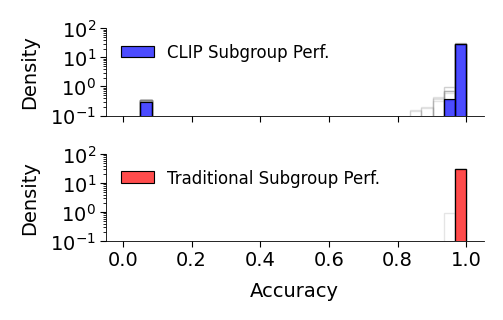

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_figure(n_rows, linewidth=3.0, axes_height=1.5, axes_width_fraction=0.8,
                  top_margin_inches=0.3, bottom_margin_inches=0.3, vertical_spacing_inches=0.2):
    """
    Creates a figure with n_rows subplots where each subplot (the drawing area)
    has the same fixed width and height.

    Parameters:
      - n_rows: Number of rows of subplots.
      - linewidth: Total figure width in inches.
      - axes_height: Desired height of each subplot's drawing area (in inches).
      - axes_width_fraction: Fraction of the total width that the drawing area should occupy.
      - top_margin_inches, bottom_margin_inches: Top and bottom margins (in inches).
      - vertical_spacing_inches: Vertical space between subplots (in inches).

    Returns:
      - fig: The created figure.
      - axes: A list (or array) of axes objects.
    """
    # Compute overall figure height so that each axes is axes_height tall.
    fig_height = top_margin_inches + bottom_margin_inches + n_rows * axes_height + (n_rows - 1) * vertical_spacing_inches

    # Create the figure with the total width and computed height.
    fig, axes = plt.subplots(n_rows, 1, figsize=(linewidth, fig_height), sharex=True)

    # Determine normalized margins so that the axes drawing area has fixed size.
    left = (1 - axes_width_fraction) / 2
    right = 1 - left
    bottom = bottom_margin_inches / fig_height
    top = 1 - top_margin_inches / fig_height
    # hspace is given relative to the axes height.
    hspace = vertical_spacing_inches / axes_height

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
    return fig, axes
    
with plt.style.context("./plot_style.txt"):
    cm = 1/2.54  # centimeters in inches
    # Create subplots ONCE
    textwidth = 12.19826*cm
    #fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(textwidth/2, textwidth/3))
    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(textwidth/2, textwidth/2))
    #fig, (ax1, ax2) = create_figure(n_rows=2, axes_height=textwidth/10, axes_width_fraction=0.7)
    fig, (ax1, ax2) = create_figure(n_rows=2, linewidth=textwidth/2, axes_height=textwidth/14, axes_width_fraction=0.7)

    
    # Create a figure and axis.
    
 
    # Assume df is your DataFrame.
    # Define meta and discrimination column names.
    meta_subgroup_cols = [col for col in df.columns
                        if col.startswith("meta_acc_") and col != "meta_avg_acc"]
    meta_overall = "meta_avg_acc"
 
    disc_subgroup_cols = [col for col in df.columns
                        if col.startswith("disc_acc_") and col != "disc_avg_acc"]
    if "disc_avg_acc" in df.columns:
        disc_overall = "disc_avg_acc"
    elif "disc_acc_jitter" in df.columns:
        disc_overall = "disc_acc_jitter"
    else:
        raise ValueError("No discrimination overall accuracy column found.")
 
    # Optional: Define bins that span the range of both meta and disc accuracies.
    # This ensures both subplots share the same binning.
    # First, gather all meta and disc values.

    # Suppose these are your overall columns for meta and disc:
    meta_columns = [meta_overall] + meta_subgroup_cols
    disc_columns = [disc_overall] + disc_subgroup_cols
    
    # Compute the global min and max from all relevant columns
    global_min = min([df[col].min() for col in meta_columns + disc_columns])
    global_max = max([df[col].max() for col in meta_columns + disc_columns])
    
    # Generate 21 evenly spaced edges for 20 bins
    common_edges = np.linspace(global_min, global_max, 30)
 
    # Bottom subplot: Discrimination Accuracy Distribution using histograms
    #for col in disc_subgroup_cols:
        #sns.histplot(df[col], bins=bins, stat="percent", element="step", fill=False,
        #             color="gray", alpha=0.3, ax=ax2)
    # Plot the overall discrimination accuracy in red (overlaid)
    for col in disc_perf_columns:
        sns.histplot(df[col], bins=common_edges, stat="density", element="bars", fill=None,
                    color="gray", alpha=0.2, ax=ax1)
    sns.histplot(df[disc_overall], bins=common_edges, stat="density", element="bars", fill=True,
                color="blue", alpha=0.7, label="CLIP Subgroup Perf.", ax=ax1)
    # sns.kdeplot(df[disc_overall], color="blue", linewidth=1, label="Discovered Subgroup Perf.", ax=ax2)
 
    #ax2.set_title("Discovered Subgroups")
    # ax2.set_xlabel("ACC")
    ax1.set_ylabel("Density")
    ax1.set_ylim(0.1, 100)
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_yscale("log")
    ax1.legend(frameon=False, loc="upper left")
    
    # Bottom subplot: Meta Accuracy Distribution using histograms
    for col in meta_subgroup_cols:
        sns.histplot(df[col], bins=common_edges, stat="density", element="bars", fill=None,
                    color="gray", alpha=0.2, ax=ax2)
    # Plot the overall meta accuracy in red (overlaid)
    sns.histplot(df[meta_overall], bins=common_edges, stat="density", element="bars", fill=True,
                color="red", alpha=0.7, label="Traditional Subgroup Perf.", ax=ax2)
    # sns.kdeplot(df[meta_overall], color="red", linewidth=1, label="Avg. Metadata-based Perf.", ax=ax1)
 
 
    #ax1.set_title("Metadata-based Subgroups")
    ax2.set_ylabel("Density")
    ax2.set_ylim(0.1, 100)
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_yscale("log")
    ax2.set_xlabel("Accuracy")
    ax2.legend(frameon=False, loc="upper left")


    plt.savefig("l3_skin_plot_w50_log.pdf")#, bbox_inches="tight")
    plt.show()

# Analysis of the subgroups

In [147]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import re

def create_figure(n_rows, linewidth=3.0, axes_height=1.5, axes_width_fraction=0.8,
                  top_margin_inches=0.3, bottom_margin_inches=0.3, vertical_spacing_inches=0.2):
    """
    Creates a figure with n_rows subplots where each subplot (the drawing area)
    has the same fixed width and height.

    Parameters:
      - n_rows: Number of rows of subplots.
      - linewidth: Total figure width in inches.
      - axes_height: Desired height of each subplot's drawing area (in inches).
      - axes_width_fraction: Fraction of the total width that the drawing area should occupy.
      - top_margin_inches, bottom_margin_inches: Top and bottom margins (in inches).
      - vertical_spacing_inches: Vertical space between subplots (in inches).

    Returns:
      - fig: The created figure.
      - axes: A list (or array) of axes objects.
    """
    # Compute overall figure height so that each axes is axes_height tall.
    fig_height = top_margin_inches + bottom_margin_inches + n_rows * axes_height + (n_rows - 1) * vertical_spacing_inches

    # Create the figure with the total width and computed height.
    fig, axes = plt.subplots(n_rows, 1, figsize=(linewidth, fig_height), sharex=True)

    # Determine normalized margins so that the axes drawing area has fixed size.
    left = (1 - axes_width_fraction) / 2
    right = 1 - left
    bottom = bottom_margin_inches / fig_height
    top = 1 - top_margin_inches / fig_height
    # hspace is given relative to the axes height.
    hspace = vertical_spacing_inches / axes_height

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
    return fig, axes


def safe_partial_auc(y_true, y_pred, min_tpr=0.8):
    # Check if there are enough positive samples
    if y_true.sum() < 1:
        return np.nan  # or another default value
    try:
        return partial_auc(y_true, y_pred, min_tpr=min_tpr)
    except Exception:
        return np.nan

# --- Sample Data: Replace with your file paths if reading from disk ---
data = "./results/results_persample_l3_isic24_valtest_clip_imagenet_multiple.csv"
df = pd.read_csv(data)
df = df[df["split"] == "test"]

df = df.pivot_table(
    index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
    columns=['seed', 'weight', 'n_slices'],
    values='discovered_subgroup_idx'
).reset_index()

def flatten_column(col):
    # If the column is a tuple with exactly 3 elements,
    # assume it's from the pivoted values (seed, weight, n_slices)
    #print(len(col), col)
    if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
        seed, weight, n_slices = col
        return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
    # If it's a tuple with a single element, assume it's an index column
    elif isinstance(col, tuple) and len(col) == 1:
        return col[0]
    return col[0]

def extract_w_number(text):
    match = re.search(r"_w(\d+)_s", text)
    if match:
        return float(match.group(1))  # Convert to integer if needed
    return None  # Return None if no match is found

df.columns = [flatten_column(col) for col in df.columns]

#md_df['name'] = md_df['name'].str.replace(r'^.*train/', 'train/', regex=True)

#df = pd.merge(df, md_df, how="inner", on="name")

# Convert predictions into binary classifications (assuming threshold of 0.5)
df["y_pred_binary"] = (df["y_pred"] >= 0.5).astype(int)

disc_perf_columns = [col for col in df.columns if (col.startswith("discovered_subgroup_idx_"))]#and "_w20.0_s" in col)]

# --- Compute Discovered Subgroup Performance ---
for col in disc_perf_columns:

    #disc_perf = df.groupby("discovered_subgroup_idx").apply(
    disc_perf = df.groupby(col).apply(
        lambda x: pd.Series({
            #"disc_mean": x["y_pred"].mean(),
            #"disc_std": x["y_pred"].std(),
            #"disc_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            "disc_acc": (x["y_pred_binary"] == x["y_true"]).mean(),  # Accuracy
            "amt_pos": x["y_true"].sum(),
            "amt_neg": (1 - x["y_true"]).sum(),
            "disc_auc_80": safe_partial_auc(x["y_true"], x["y_pred"], min_tpr=0.8),
            "class_ratio": x["y_true"].mean(),
            "balanced_acc": balanced_accuracy_score(x["y_true"], x["y_pred_binary"]),
            #"disc_sensitivity": x[x["y_true"] == 1]["y_pred_binary"].mean(),  # TP / (TP + FN)
            #"disc_specificity": 1 - x[x["y_true"] == 0]["y_pred_binary"].mean(),  # TN / (TN + FP)
            #"disc_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2  # Balanced Accuracy
        })
    ).reset_index()
    print(disc_perf)
    #disc_perf.rename(columns={"disc_acc": f"disc_acc_{col}"}, inplace=True)
    #df = df.merge(disc_perf, on=col, how="left")

disc_perf_columns = [col for col in df.columns if col.startswith("disc_acc_")]
df["disc_avg_acc"] = df[disc_perf_columns].mean(axis=1)


/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true

    discovered_subgroup_idx_r42_w0.001_s15  disc_acc  amt_pos  amt_neg  \
0                                        0  0.999446      1.0   1803.0   
1                                        1  0.999648      2.0   5681.0   
2                                        2  0.997917      2.0   2878.0   
3                                        3  0.995806      1.0   2145.0   
4                                        4  0.998047      0.0    512.0   
5                                        5  0.994830      1.0   2707.0   
6                                        6  0.997386      2.0   2293.0   
7                                        7  1.000000      0.0   1686.0   
8                                        8  1.000000      0.0   2482.0   
9                                        9  0.972447     28.0  16050.0   
10                                      10  0.996217      1.0   4228.0   
11                                      11  0.994269      0.0   5933.0   
12                                    

/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/sklearn/metrics/_cl